In [8]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os
import zipfile
import json
import fiona
from fiona.crs import from_epsg
import pylab as pl
import shapely
%pylab inline

pui_Data = os.getenv("PUIDATA")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def get_data():
    '''
    Download data for Homework 11, Assigment 2 and move to HW11 PUI Data Folder, including:
    1.  Census Data for Businesses by Zipcode
    2.  NYC Zipcodes Shapefile 
    '''

    # Download NYC Zipcode Geojson File in HW11 githib repository
    
    data_url = "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/\
    HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson"
    
    !curl -O "{data_url}"

    # Download Census Data for Business by Zip Code (Code provided by professor)

    !for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done 
    !for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done
    !for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
    !for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done
    
get_data()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0    21    0    21    0     0    147      0 --:--:-- --:--:-- --:--:--  2100
--2016-12-14 17:30:21--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-12-14 17:35:25--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
  (try: 2) => “zbp93totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... ^C
--2016-12-14 17:39:57--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip.2”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9

In [21]:
#create a new dataframe with values from all census business data files, 
years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07',
        '08', '09', '10', '11', '12', '13', '14']
CombinedValues = pd.DataFrame()
for year in years:
    fname = 'zbp' + year + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    each_year = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    each_year['year'] = year
    each_year.rename(columns = {"est" : "est"+ str(year)}, inplace = True)
    each_year.rename(columns = {"EST" : "est"+ str(year)}, inplace = True)
    CombinedValues = pd.concat([CombinedValues, each_year], axis=0)
    
CombinedValues.head()

,AP,EMP,EMPFLAG,NAME,QP1,ZIP,ap,ap_nf,city,cty_name,...,est96,est97,est98,est99,name,qp1,qp1_nf,stabbr,year,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,155158.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Agawam, MA",33601.0,NaN,NaN,94,1001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,127367.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Amherst, MA",28924.0,NaN,NaN,94,1002.0
2,NaN,NaN,NaN,NaN,NaN,NaN,1604.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Amherst, MA",367.0,NaN,NaN,94,1003.0
3,NaN,NaN,NaN,NaN,NaN,NaN,4302.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Amherst, MA",844.0,NaN,NaN,94,1004.0
4,NaN,NaN,NaN,NaN,NaN,NaN,13521.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Barre, MA",3010.0,NaN,NaN,94,1005.0


In [22]:
CombinedValues_reduced = CombinedValues
CombinedValues_reduced.drop(CombinedValues_reduced.columns[[0,1,2,3,4,36,37,38,39]], axis=1, inplace=True)
CombinedValues_reduced.head()

,ZIP,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est00,est01,...,est13,est14,est94,est95,est96,est97,est98,est99,name,qp1
0,NaN,155158.0,NaN,NaN,NaN,6198.0,NaN,NaN,NaN,NaN,...,NaN,NaN,439.0,NaN,NaN,NaN,NaN,NaN,"Agawam, MA",33601.0
1,NaN,127367.0,NaN,NaN,NaN,6073.0,NaN,NaN,NaN,NaN,...,NaN,NaN,450.0,NaN,NaN,NaN,NaN,NaN,"Amherst, MA",28924.0
2,NaN,1604.0,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,"Amherst, MA",367.0
3,NaN,4302.0,NaN,NaN,NaN,210.0,NaN,NaN,NaN,NaN,...,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,"Amherst, MA",844.0
4,NaN,13521.0,NaN,NaN,NaN,678.0,NaN,NaN,NaN,NaN,...,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,"Barre, MA",3010.0


In [23]:
CombinedValues_red = CombinedValues_reduced
CombinedValues_red.drop(CombinedValues_reduced.columns[[1,2,3,4,5,6,7,16,29,30]], axis=1, inplace=True)
CombinedValues_red.head()

,ZIP,est00,est01,est02,est03,est04,est05,est06,est07,est09,...,est11,est12,est13,est14,est94,est95,est96,est97,est98,est99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,439.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN


In [28]:
CombinedValues_red.shape

(828791, 21)

In [59]:
##I took this code from Scott Smith's explanation and notebook.

year = 94
df_yr = {}
while year != 15:
    yr = str(year)
    if year < 20:
        estyr = "est{:4d}".format(year + 2000)
    else:
        estyr = "est{:4d}".format(year + 1900)
    zf = zipfile.ZipFile(pui_Data + "/zbp{:02}totals.zip".format(year))
    df_yr[yr] = pd.read_csv(zf.open("zbp{:02d}totals.txt".format(year)))

    df_yr[yr].rename(columns={"est" : estyr}, inplace=True)
    df_yr[yr].rename(columns={"EST" : estyr}, inplace=True)

    if "ZIP" in df_yr[yr].columns:
        df_yr[yr].rename(columns={"ZIP" : "zip"})
  
    if "zip" in df_yr[yr].columns:
        df_yr[yr].set_index(["zip"], inplace=True)
 
    df_yr[yr] = df_yr[yr].loc[(df_yr[yr].index >= 10000) & (df_yr[yr].index < 11500)]
    df_yr[yr] = df_yr[yr].loc[(df_yr[yr].index < 10500) | (df_yr[yr].index >= 11000)]
    
    df_yr[yr] = df_yr[yr][[estyr]]
    year = (year + 1) % 100

df = df_yr["94"]
year = 95

while year != 15:
    df = pd.merge(df, df_yr[str(year)], how='inner', left_index=True, right_index=True)
    year = (year + 1) % 100
df.head(5)

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2005,est2006,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014
10001,6999,7088,7075,7154,172,1,3,11,1,7084,...,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
10002,1784,1819,1919,2049,26,5,5,1,217,2402,...,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
10003,3256,3377,3417,3535,247,19,48,1,18,3704,...,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
10004,1115,1124,1133,1173,70,11,1000,7,31,1252,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
10005,1076,1109,1216,1227,466,97,58,32,12,1200,...,1214,1259,1273,1291,1274,1266,1301,1273,1296,1321


In [60]:
mean = df.mean(axis=1)
stdev = df.std(axis=1)
print(mean.head(5))
print(stdev.head(5))

10001    5540.761905
10002    1952.142857
10003    2975.666667
10004    1055.809524
10005     975.571429
dtype: float64
10001    3155.346018
10002    1149.859265
10003    1692.864623
10004     527.352503
10005     493.416110
dtype: float64


In [69]:
summ = pd.DataFrame([means, stds]).transpose()
summ.rename(columns={0 : "emean", 1 : "estd"}, inplace=True)
summ.head(5)

,emean,estd
10001,413.624493,1261.954497
10002,146.565984,448.541754
10003,221.374539,677.807534
10004,74.061024,234.422065
10005,68.603380,217.156174


In [70]:
df = pd.merge(df, summ, how='inner', left_index=True, right_index=True)
df.head(5)

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2009,est2010,est2011,est2012,est2013,est2014,mean,std,emean,estd
10001,6999,7088,7075,7154,172,1,3,11,1,7084,...,7305,7241,7227,7235,7273,7369,5540.761905,3155.346018,413.624493,1261.954497
10002,1784,1819,1919,2049,26,5,5,1,217,2402,...,2775,2872,2912,2954,2988,2972,1952.142857,1149.859265,146.565984,448.541754
10003,3256,3377,3417,3535,247,19,48,1,18,3704,...,4099,4113,4159,4214,4277,4333,2975.666667,1692.864623,221.374539,677.807534
10004,1115,1124,1133,1173,70,11,1000,7,31,1252,...,1379,1398,1404,1442,1479,1554,1055.809524,527.352503,74.061024,234.422065
10005,1076,1109,1216,1227,466,97,58,32,12,1200,...,1274,1266,1301,1273,1296,1321,975.571429,493.416110,68.603380,217.156174


In [71]:
normed = df
# Normalize each time series by subtract the series mean from each column and dividing by
# the series standard deviation
for yr in range(1994, 2015):
    col = "est{}".format(yr)
    normed[col] = (normed[col] - normed.emean) / normed.estd
normed.head(5)

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2009,est2010,est2011,est2012,est2013,est2014,mean,std,emean,estd
10001,5.218394,5.288919,5.278618,5.341219,-0.191468,-0.326973,-0.325388,-0.319048,-0.326973,5.285750,...,5.460875,5.410160,5.399066,5.405405,5.435517,5.511590,5540.761905,3155.346018,413.624493,1261.954497
10002,3.650572,3.728603,3.951547,4.241376,-0.268795,-0.315614,-0.315614,-0.324532,0.157029,5.028370,...,5.859954,6.076210,6.165388,6.259025,6.334826,6.299155,1952.142857,1149.859265,146.565984,448.541754
10003,4.477120,4.655636,4.714650,4.888741,0.037806,-0.298572,-0.255787,-0.325128,-0.300048,5.138074,...,5.720836,5.741490,5.809356,5.890500,5.983447,6.066066,2975.666667,1692.864623,221.374539,677.807534
10004,4.440448,4.478840,4.517233,4.687865,-0.017324,-0.269006,3.949880,-0.286070,-0.183690,5.024864,...,5.566622,5.647672,5.673267,5.835368,5.993203,6.313139,1055.809524,527.352503,74.061024,234.422065
10005,4.639042,4.791006,5.283739,5.334394,1.830004,0.130766,-0.048828,-0.168558,-0.260657,5.210060,...,5.550828,5.513988,5.675163,5.546223,5.652138,5.767262,975.571429,493.416110,68.603380,217.156174


In [72]:
normed.drop(["emean", "estd"], axis=1, inplace=True)

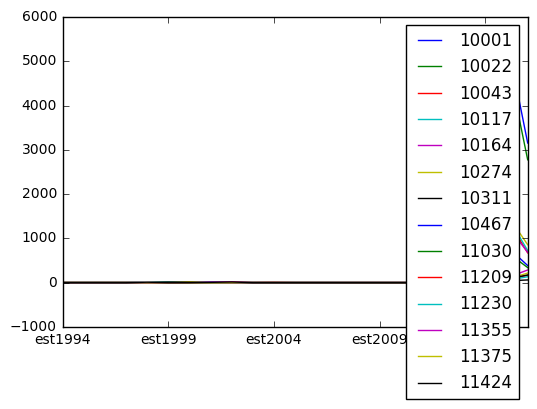

In [73]:
samp = normed.index[::20]
sampdf = normed.loc[samp]
sampdf.transpose().plot()